In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
import altair as alt
alt.data_transformers.enable('json')
#from scipy import stats
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform

from math import pi

In [ ]:
types = {'user' : 'category', 'sport' : 'category'}

In [ ]:
tours = pd.read_csv('tour-events.csv', dtype = types, parse_dates = ['timestamp'])
tours.head()

In [ ]:
len(tours.user.unique())

In [ ]:
tours.info()

In [ ]:
tours['date'] = pd.to_datetime(tours.timestamp.dt.date)

In [ ]:
last_days = tours.groupby('user')['date'].max().reset_index()

In [ ]:
sports = tours.groupby(['user', 'sport']).agg({'date' : [(lambda x : len(x.unique())), min, max]}).reset_index()

In [ ]:
sports.columns = sports.columns.droplevel(0)
sports.columns = ['user', 'sport', 'active_days', 'first_date', 'last_date']

In [ ]:
sports.head()

In [ ]:
sports.sport.unique()

In [ ]:
sports['sports_period'] = ((sports.last_date - sports.first_date).dt.days) + 1

sports['sports_frequency'] = sports.active_days / sports.sports_period

In [ ]:
data = sports.pivot_table(index = ['user'], columns = 'sport', values = ['active_days', 'sports_frequency'], fill_value = 0)
# flatten column names
data.columns = list(map("_".join, data.columns))

In [ ]:
data = data.merge(last_days, on = 'user')
data = data.rename({'date' : 'last_usage_date'}, axis='columns')
data['days_inactive'] = (data.last_usage_date.max() - data.last_usage_date).dt.days

In [5]:
#data.to_parquet('data.parq', compression = 'uncompressed')
data = pd.read_parquet('data.parq')

In [ ]:
plot_data = data.drop('last_usage_date', axis = 'columns').melt(id_vars = 'user')

In [ ]:
plot_data.head()

In [ ]:
alt.Chart(plot_data).mark_bar().encode(alt.X('value:Q', bin = alt.Bin(maxbins=500)), y = 'count():Q').facet(row = 'variable:N').resolve_scale(x = 'independent')

In [ ]:
def skew_plot(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num = data.select_dtypes(include=numerics)

    # Now we create a Series with the skewness and plot in an ordered line graph.
    skew = pd.DataFrame(sp.skew(num), num.keys())
    # Sorting values.
    skew=skew.sort_values(by=0, ascending=False)
    # Setting the size.
    plt.figure(figsize=(15,7))
    # Plotting the skew.
    plt.plot(skew)
    # Rotating the features labels.
    plt.xticks(rotation=45, fontsize=8)
    # Adding labels.
    plt.xlabel('Numerical Features', fontsize=10)
    plt.ylabel('Skew', fontsize=10)
    # Adding limit lines.
    plt.axhline(y=1, c='red')
    plt.axhline(y=-1, c='red', )
    plt.show()

most dimensions are zero-inflated

## Clustering

In [6]:
input = data.drop(['user', 'last_usage_date'], axis = 'columns')

In [ ]:
input.describe()

In [ ]:
input.hist(bins=25, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False, figsize = (20, 10), sharex = False)
#plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

In [ ]:
skew_plot(input)

raw input

In [ ]:
cov = ['spherical', 'tied', 'diag', 'full']
n = np.arange(3, 16)

models = [GMM(n, covariance_type = c, random_state=0).fit(input)
          for n in n for c in cov]

In [ ]:
aic = [s.aic(input) for s in models]
bic = [s.bic(input) for s in models]


In [ ]:
# Latent Dirichlet allocation for high dimensions
# scaling : needed only when using priors
shil_scores = list()


for m in models:
    l = m.predict(input)
    s = metrics.silhouette_score(input, l, metric='euclidean')
    shil_scores.append(s)

In [ ]:
results = pd.DataFrame({'model' : models, 'aic' : aic, 'bic' : bic, 'shil_score' : shil_scores})

In [ ]:
# best
results.model[13]#.head()

In [ ]:
results.loc[13]

In [ ]:
input_sq = np.sqrt(input)

In [ ]:
input_sq.hist(bins=25, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False, figsize = (20, 10), sharex = False)

In [ ]:
skew_plot(input_sq)

In [ ]:
cov = ['spherical', 'tied', 'diag', 'full']
n = np.arange(3, 16)

models = [GMM(n, covariance_type = c, random_state=0).fit(input_sq)
          for n in n for c in cov]

In [ ]:
aic = [s.aic(input_sq) for s in models]
bic = [s.bic(input_sq) for s in models]

shil_scores = list()

for m in models:
    l = m.predict(input_sq)
    s = metrics.silhouette_score(input_sq, l, metric='euclidean')
    shil_scores.append(s)

In [ ]:
results_sq = pd.DataFrame({'model' : models, 'aic' : aic, 'bic' : bic, 'shil_score' : shil_scores})

In [ ]:
results_sq
# no good

### scaled variables

In [7]:
input_sc = input.apply(lambda x : (x - np.mean(x)) / np.std(x), axis = 'columns')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde4c78a1d0>,
      dtype=object)

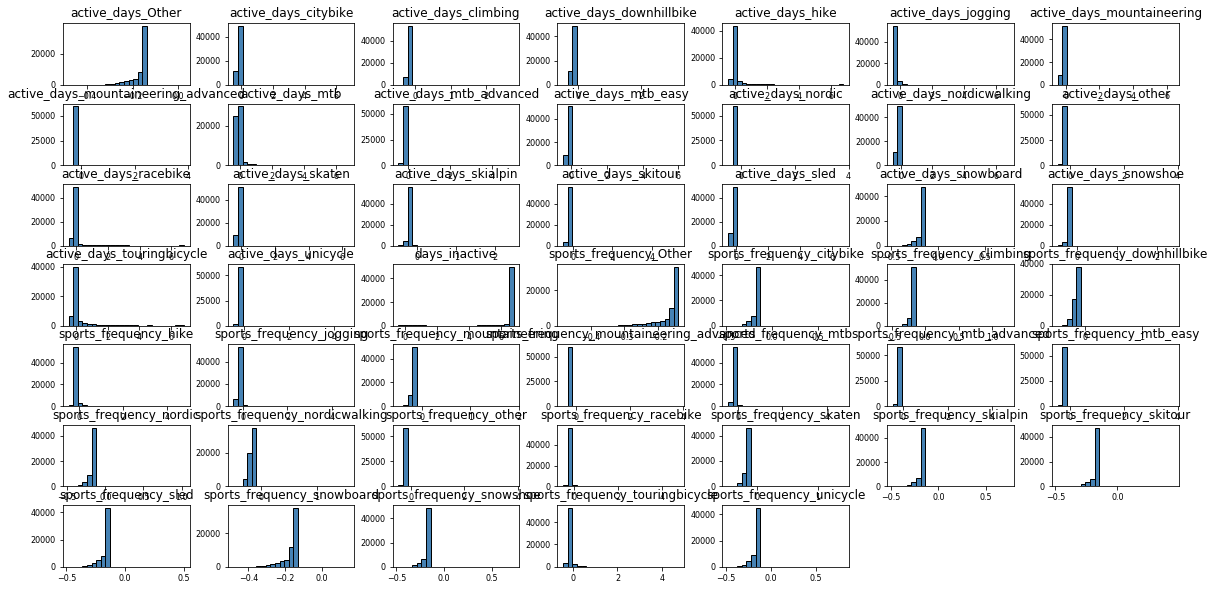

In [8]:
input_sc.hist(bins=25, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False, figsize = (20, 10), sharex = False)

In [ ]:
skew_plot(input_sc)

In [9]:
cov = ['spherical', 'tied', 'diag', 'full']
n = np.arange(3, 16)

models = [GMM(n, covariance_type = c, random_state=0, max_iter = 1000).fit(input_sc)
          for n in n for c in cov]

In [ ]:
aic = [s.aic(input_sc) for s in models]
bic = [s.bic(input_sc) for s in models]

shil_scores = list()

for m in models:
    l = m.predict(input_sc)
    s = metrics.silhouette_score(input_sc, l, metric='euclidean')
    shil_scores.append(s)

In [ ]:
results_sc = pd.DataFrame({'model' : models, 'aic' : aic, 'bic' : bic, 'shil_score' : shil_scores})

In [ ]:
results_sc.model[25]

In [ ]:
results_sc.loc[25]
gmm = results_sc.loc[25, 'model']
labels_sc = gmm.predict(input_sc)
data['label_sc'] = gmm.predict(input)

In [ ]:
data.columns

In [ ]:
categories = labels_sc.tolist()
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=input.loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=input.loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [ ]:
input.loc[0]

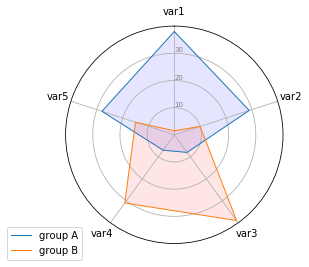

In [3]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [ ]:
from scipy.special import boxcox1p
input_bc = boxcox1p(input, 1.25)

In [ ]:
skew_plot(input_bc)

In [ ]:
cov = ['spherical', 'tied', 'diag', 'full']
n = np.arange(3, 16)

models = [GMM(n, covariance_type = c, random_state=0).fit(input_bc)
          for n in n for c in cov]

In [ ]:
aic = [s.aic(input_bc) for s in models]
bic = [s.bic(input_bc) for s in models]

shil_scores = list()

for m in models:
    l = m.predict(input_bc)
    s = metrics.silhouette_score(input_bc, l, metric='euclidean')
    shil_scores.append(s)

In [ ]:
results_bc = pd.DataFrame({'model' : models, 'aic' : aic, 'bic' : bic, 'shil_score' : shil_scores})

In [ ]:
results_bc
# none are good

In [ ]:
input_yj = pd.DataFrame(power_transform(input, method = 'yeo-johnson'))

In [ ]:
input_yj.hist(bins=25, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False, figsize = (20, 10), sharex = False)

In [ ]:
cov = ['spherical', 'tied', 'diag', 'full']
n = np.arange(3, 16)

models = [GMM(n, covariance_type = c, random_state=0).fit(input_yj)
          for n in n for c in cov]

In [ ]:
aic = [s.aic(input_yj) for s in models]
bic = [s.bic(input_yj) for s in models]

shil_scores = list()

for m in models:
    l = m.predict(input_yj)
    s = metrics.silhouette_score(input_yj, l, metric='euclidean')
    shil_scores.append(s)

In [ ]:
results_yj = pd.DataFrame({'model' : models, 'aic' : aic, 'bic' : bic, 'shil_score' : shil_scores})

In [ ]:
results_yj
# no good